# Model Definition and Evaluation
## Table of Contents
1. [Model Selection](#model-selection)
2. [Feature Engineering](#feature-engineering)
3. [Hyperparameter Tuning](#hyperparameter-tuning)
4. [Implementation](#implementation)
5. [Evaluation Metrics](#evaluation-metrics)
6. [Comparative Analysis](#comparative-analysis)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.models import Sequential, Model
from keras.layers import Activation, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix, classification_report

import keras
from keras.layers import Input, Flatten, Dense, Lambda, Reshape
from keras.datasets import mnist
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from keras.initializers import GlorotUniform


## Model Selection

Given the extreme class imbalance and the difficulty in effectively addressing it through traditional methods like synthetic data generation and cost-sensitive learning, an anomaly detection approach was pursued. **Variational Autoencoders (VAEs)** were chosen for this task due to their ability to learn a compressed representation of normal data and identify anomalies based on reconstruction error. By training the VAE on non-fraudulent data, the model can effectively capture the underlying patterns of normal transactions. Subsequently, by comparing the reconstruction loss of new data points to a defined threshold, potential fraudulent activities can be identified. This approach offers a promising avenue for addressing the challenges posed by the highly imbalanced dataset.

While other anomaly detection techniques like Isolation Forest or One-Class SVM could be considered, VAEs were selected for their ability to generate new, synthetic normal data, which can potentially enhance model performance.



## Feature Engineering

As the input data was the profiling generated from transactional data so feature engineering was already done at preprocessing state


In [ ]:
# Load the dataset
# Replace 'your_dataset.csv' with the path to your actual dataset
df = pd.read_csv('/content/drive/MyDrive/datasets/filtered_data.csv')


df.drop(['Unnamed: 0', 'predicted_fraud'], axis=1, inplace=True)

# Feature and target variable selection
# As we are training our model only on normal transactions so we will filter the fraudulent transactions
nf_df = df.copy()
nf_df = nf_df[nf_df['is_fraud'] == 0]
nf_df.drop('is_fraud', axis=1, inplace=True)

# Standarding the data
scaler = StandardScaler().fit(nf_df)
std_df = scaler.transform(nf_df)
print(std_df.shape)

(999004, 24)


In [ ]:
df.head()

,moc,dist_moc,onnet_moc,offnet_moc,int_moc,mtc,dist_mtc,onnet_mtc,offnet_mtc,int_mtc,...,max_int_moc,max_mtc,b_ratio,avg_duration_mtc,avg_duration,total_duration,lac,cell,evt_volume,is_fraud
0,0,0,0,0,0,4,4,0,0,4,...,0,20,0.0,13.25,0.0,0.0,1,1,0.0,0
1,0,0,0,0,0,1,1,0,0,1,...,0,212,0.0,212.00,0.0,0.0,1,1,0.0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0.0,0.00,0.0,0.0,2,2,0.0,0
3,1,1,0,1,0,2,1,0,0,2,...,0,666,1.0,512.00,14.0,14.0,2,3,0.0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0.0,0.00,0.0,0.0,1,1,0.0,0


## Implementation

A Variational Autoencoder (VAE) is a generative model that learns a compressed representation of input data and can generate new data points similar to the training data. It consists of an encoder that maps input to a latent space and a decoder that reconstructs the input from the latent representation.

In [ ]:
#defining input dimensions and latent dimensions
input_dim = nf_df.shape[1]
latent_dim = 2

# defning input layer
input_data = Input(shape=(input_dim,), name='encoder_input')

### Encoder

The encoder in a VAE maps the input data to a lower-dimensional latent space. This latent representation captures the underlying structure of the data and is used by the decoder to reconstruct the original input.

In [ ]:
#Encoder
x = Dense(64, activation='relu', kernel_initializer=GlorotUniform())(input_data)
x = Dense(128, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)

final_shape = K.int_shape(x)

z_mu = Dense(latent_dim, name='latent_mu')(x)   #Mean values of encoded input
z_sigma = Dense(latent_dim, name='latent_sigma')(x)  #Std dev. (variance) of encoded input

def sample_z(args):
  z_mu, z_sigma = args
  eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
  return z_mu + K.exp(z_sigma / 2) * eps

z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([z_mu, z_sigma])

encoder = Model(input_data, [z_mu, z_sigma, z], name='encoder')
print(encoder.summary())

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 24)]                 0         []                            
                                                                                                  
 dense_145 (Dense)           (None, 64)                   1600      ['encoder_input[0][0]']       
                                                                                                  
 dense_146 (Dense)           (None, 128)                  8320      ['dense_145[0][0]']           
                                                                                                  
 dense_147 (Dense)           (None, 128)                  16512     ['dense_146[0][0]']           
                                                                                            

### Decoder

The decoder in a VAE takes the latent representation generated by the encoder and reconstructs the original input data. It aims to minimize the reconstruction error, learning to capture the underlying data distribution.

In [ ]:
#defining input layer for decoder
decoder_input = Input(shape=(latent_dim, ), name='decoder_input')

In [ ]:
# Decoder
x = Dense(64, activation='relu')(decoder_input)
x = Dense(64, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(input_dim, activation='sigmoid', name='decoder_output')(x)
decoder = Model(decoder_input, x, name='decoder')
print(decoder.summary())

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_150 (Dense)           (None, 64)                192       
                                                                 
 dense_151 (Dense)           (None, 64)                4160      
                                                                 
 dense_152 (Dense)           (None, 128)               8320      
                                                                 
 dense_153 (Dense)           (None, 128)               16512     
                                                                 
 dense_154 (Dense)           (None, 64)                8256      
                                                                 
 decoder_output (Dense)      (None, 24)                1560

In [ ]:
z_decoded = decoder(z)

The VAE loss function comprises two components: reconstruction loss, typically mean squared error, measuring the difference between the original and reconstructed input, and KL divergence, ensuring the latent space distribution resembles a prior distribution, usually a standard normal distribution.


In [ ]:
#Defining Custom loss function
class CustomLayer(keras.layers.Layer):
    def vae_loss(self, x, z_decoded, z_mu, z_sigma):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)

        # Reconstruction loss (as we used sigmoid activation we can use binarycrossentropy)
        recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)

        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=-1)
        return K.mean(recon_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        z_mu = inputs[2]
        z_sigma = inputs[3]
        loss = self.vae_loss(x, z_decoded, z_mu, z_sigma)
        self.add_loss(loss, inputs=inputs)
        return x

In [ ]:
#adding custom layer
y = CustomLayer()([input_data, z_decoded, z_mu, z_sigma])

In [ ]:
#Defining Final Model

vae = Model(input_data, y, name='vae')

# Compile VAE
vae.compile(optimizer='adam', loss=None)
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 24)]                 0         []                            
                                                                                                  
 dense_145 (Dense)           (None, 64)                   1600      ['encoder_input[0][0]']       
                                                                                                  
 dense_146 (Dense)           (None, 128)                  8320      ['dense_145[0][0]']           
                                                                                                  
 dense_147 (Dense)           (None, 128)                  16512     ['dense_146[0][0]']           
                                                                                                

In [ ]:
history = vae.fit(std_df, None, epochs = 10, batch_size = 500, validation_split = 0.2)

Epoch 1/10
1599/1599 [==============================] - 31s 17ms/step - loss: -4.4862 - val_loss: -4.8691
Epoch 2/10
1599/1599 [==============================] - 24s 15ms/step - loss: -4.9962 - val_loss: -5.0119
Epoch 3/10
1599/1599 [==============================] - 26s 16ms/step - loss: -5.0970 - val_loss: -5.0944
Epoch 4/10
1599/1599 [==============================] - 27s 17ms/step - loss: -5.1328 - val_loss: -5.0996
Epoch 5/10
1599/1599 [==============================] - 23s 15ms/step - loss: -5.1645 - val_loss: -5.1058
Epoch 6/10
1599/1599 [==============================] - 26s 16ms/step - loss: -5.1682 - val_loss: -5.1551
Epoch 7/10
1599/1599 [==============================] - 24s 15ms/step - loss: -5.2006 - val_loss: -5.1670
Epoch 8/10
1599/1599 [==============================] - 27s 17ms/step - loss: -5.1694 - val_loss: -5.1992
Epoch 9/10
1599/1599 [==============================] - 26s 16ms/step - loss: -5.2191 - val_loss: -5.1644
Epoch 10/10
1599/1599 [=======================

## Evaluation Metrics

[Clearly specify which metrics you'll use to evaluate the model performance, and why you've chosen these metrics.]


In [ ]:
std_all_df = scaler.transform(df.drop('is_fraud', axis=1))  # Apply the same scaling
X_pred = vae.predict(std_all_df)
reconstruction_errors = np.mean(np.power(std_all_df - X_pred, 2), axis=1)

31225/31225 [==============================] - 59s 2ms/step


In [ ]:
threshold = np.percentile(reconstruction_errors, 99.9)  # This can be tuned
fraud_indices = np.where(reconstruction_errors > threshold)[0]

In [ ]:
print(f"Detected fraud cases: {len(fraud_indices)}")

Detected fraud cases: 1000


In [ ]:
mu, _, _ = encoder.predict(std_all_df)

31225/31225 [==============================] - 68s 2ms/step


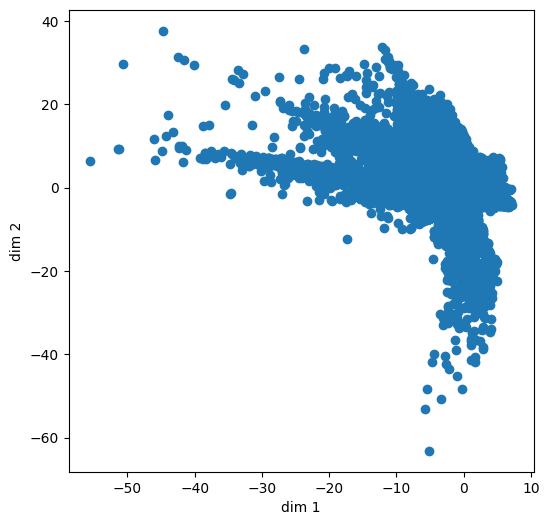

In [ ]:
#Plot dim1 and dim2 for mu
plt.figure(figsize=(6, 6))
plt.scatter(mu[:, 0], mu[:, 1])
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.show()

In [ ]:
df['predicted_fraud'] = reconstruction_errors > threshold

In [ ]:
f1_score(df['is_fraud'], df['predicted_fraud'])

0.0033641715727502105

In [ ]:
cm = confusion_matrix(df['is_fraud'], df['predicted_fraud'])

In [ ]:
# Create pandas DataFrame from confusion matrix
cm_df = pd.DataFrame(cm, index=[0,1], columns=[0,1])

# Print or display the confusion matrix DataFrame
print(cm_df)

# Generate classification report
report = classification_report(df['is_fraud'], df['predicted_fraud'], output_dict=True)
# Print classification report in a more readable format (optional)
print(pd.DataFrame(report).transpose())

        0    1
0  998006  998
1     187    2
              precision    recall  f1-score        support
0              0.999813  0.999001  0.999407  999004.000000
1              0.002000  0.010582  0.003364     189.000000
accuracy       0.998814  0.998814  0.998814       0.998814
macro avg      0.500906  0.504792  0.501385  999193.000000
weighted avg   0.999624  0.998814  0.999218  999193.000000


## Comparative Analysis

[Compare the performance of your model(s) against the baseline model. Discuss any improvements or setbacks and the reasons behind them.]


In [ ]:
# Comparative Analysis code (if applicable)
# Example: comparing accuracy of the baseline model and the new model
# print(f"Baseline Model Accuracy: {baseline_accuracy}, New Model Accuracy: {new_model_accuracy}")
